In [1]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import json
import numpy as np
import os

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

## Dataset

### MNIST

In [5]:
training_data = datasets.MNIST(
    root="./benchmark/mnist/data/",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

testing_data = datasets.MNIST(
    root="./benchmark/mnist/data/",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

dataset="mnist"

### EMNIST

In [ ]:
training_data = datasets.EMNIST(
    root="./benchmark/emnist/data/",
    split="letters",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

testing_data = datasets.EMNIST(
    root="./benchmark/emnist/data/",
    split="letters",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

dataset="emnist"

### CIFAR10

In [2]:
training_data = datasets.CIFAR10(
    root="../PersonalizedFL/myPFL/benchmark/cifar10/data/",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

testing_data = datasets.CIFAR10(
    root="../PersonalizedFL/myPFL/benchmark/cifar10/data/",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

dataset="cifar10"

### Fashion MNIST

In [ ]:
training_data = datasets.FashionMNIST(
    root="./benchmark/fmnist/data", 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

testing_data = datasets.FashionMNIST(
    root="./benchmark/fmnist/data", 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

### CIFAR100

In [2]:
training_data = datasets.CIFAR100(
    root="../PersonalizedFL/myPFL/benchmark/cifar100/data/",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

testing_data = datasets.CIFAR100(
    root="../PersonalizedFL/myPFL/benchmark/cifar100/data/",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

dataset="cifar100"

### ImageNet

In [ ]:
training_data = datasets.ImageNet(
    root="./benchmark/cifar100/data/",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

testing_data = datasets.ImageNet(
    root="./benchmark/cifar100/data/",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

### TINY-ImageNet

In [2]:
data_folder = "../datasets/data/tiny-imagenet-200/train"

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
total_data = datasets.ImageFolder(data_folder, transform=transform)
training_data, testing_data = random_split(total_data, [80000, 20000], generator=torch.Generator().manual_seed(200200))

### Medical-Mnist

In [2]:
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import random_split
import os
import torch


transform=transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

data_folder="../datasets/data/medical-mnist"
dataset=datasets.ImageFolder(root=data_folder,transform=transform)
training_data, testing_data = random_split(dataset, [40000, len(dataset) - 40000], generator=torch.Generator().manual_seed(200200))

### Brain-mri

In [2]:
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import random_split
import os, torch

In [3]:
data_folder="../datasets/data/brain-tumor-mri-dataset"
transform= transforms.Compose([
    transforms.Resize(size= (128,128)),
    transforms.ToTensor(),
])
training_data = datasets.ImageFolder(root=os.path.join(data_folder, "Training"), transform=transform, target_transform = None)
testing_data = datasets.ImageFolder(root=os.path.join(data_folder, "Testing"), transform=transform)

## Division algorithm

### Pathological heterogeneity

**Each client:**

1. Contains no more than 3 labels
2. Each label has 8 to 20 samples
3. There're at least 5 * #numclass clients

In [ ]:
import numpy as np
import os
import math

In [ ]:
total_labels = np.unique(training_data.targets).tolist()
len(total_labels)
print(total_labels)

min_label_per_client = 1
max_label_per_client = 3

min_sample_per_client = 5
max_sample_per_client = 20

# num_clients = 5 * len(total_labels)
num_clients = 100

total_label = len(total_labels)
label_list = [i for i in total_labels]
label_per_client = 2

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

client_labels = []
not_passed_label_list = label_list.copy()

for client_id in range(num_clients):
    label_per_client = np.random.randint(min_label_per_client, max_label_per_client + 1)
    this_set = np.random.choice(label_list, label_per_client, replace=False)
    client_labels.append(list(this_set))
    not_passed_label_list = list(set(not_passed_label_list) - set(this_set))

if len(not_passed_label_list) > 0:
    print("Uncover", len(not_passed_label_list), "labels !")
    exit(0)
else:
    print("Uncover", len(not_passed_label_list), "labels !")

samples_details = []

for client_idx, client_label in zip(range(num_clients), client_labels):
    sample_this_client = []
    
    for label in client_label:
        sample_per_client = np.random.randint(min_sample_per_client, max_sample_per_client + 1)
        sample_this_client.append(sample_per_client)
        
        idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
        idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
        
        label_1_idxes = np.random.choice(idxes_1, sample_per_client, replace=False)
        label_2_idxes = np.random.choice(idxes_2, int(sample_per_client/4), replace=False)
        
        training_dict_client[client_idx] += label_1_idxes.tolist()
        testing_dict_client[client_idx] += label_2_idxes.tolist()
        
        training_idxs_labels[label_1_idxes] -= 100
        testing_idxs_labels[label_2_idxes] -= 100
    
    samples_details.append(sample_this_client)


dis_mtx = np.zeros([num_clients, total_label])
for client_id in range(len(client_labels)):
    client_label = client_labels[client_id]
    client_samples = samples_details[client_id]
    
    for label, num_samples in zip(client_label, client_samples):
        dis_mtx[client_id][total_labels.index(label)] = num_samples

In [ ]:
dis_mtx

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/mnist/sparse/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/mnist_sparse.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/mnist_sparse_test.json", "w"), cls=NumpyEncoder)
np.savetxt(f"{savepath}/mnist_sparse_stat.csv", dis_mtx, fmt="%d", delimiter=",")

#### Quantity skew

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_clients=10
num_class=10
data_volume=50000
per_class_volume=int(data_volume/num_class)

sample_idx = [i for i in range(data_volume)]
label_idx = []
for i in range(num_class):
    label_idx += [i] * per_class_volume

num_shards=100
per_shard_volume=int(data_volume/num_shards)
per_client_max_shards=int(num_shards/num_clients)

dis_mtx = np.zeros([num_clients, num_class])
for client_id in range(num_clients):
    this_client_shards = np.random.randint(1, per_client_max_shards)
    this_client_sample_idxes = np.random.choice(sample_idx, size=this_client_shards * per_shard_volume, replace=False)
    sample_idx = list(set(sample_idx) - set(this_client_sample_idxes))
    
    this_client_label_set = [label_idx[i] for i in this_client_sample_idxes]
    labels, volumes = np.unique(this_client_label_set, return_counts=True)
    for lab, vol in zip(labels, volumes):
        dis_mtx[client_id][lab] += vol

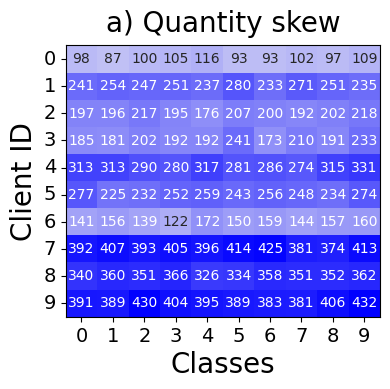

In [18]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(dis_mtx, 
                vmin=0, vmax=np.ceil(np.max(dis_mtx)), 
                fmt=".0f", annot=True, 
                cmap=sns.color_palette("light:b", as_cmap=True), cbar=False,
                # cbar_kws = dict(use_gridspec=False,location="left"),
                mask=(dis_mtx==0))

ax.set_yticklabels(labels=[i for i in range(num_clients)], rotation=0, fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0, fontsize=14)
ax.set_xlabel("Classes", fontsize=20)
ax.set_ylabel("Client ID", fontsize=20)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title("a) Quantity skew", fontsize=20, y=1.02)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'quantity-skewed.svg'
plt.tight_layout()
plt.savefig(image_name, format=image_format, dpi=1200)

#### Label skew

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_clients=10
num_class=10
data_volume=50000
per_client_volume=data_volume/num_clients

dis_mtx = np.zeros([num_clients, num_class])
for client_id in range(num_clients):
    this_client_numclass = np.random.randint(2,3)
    this_client_label_set = np.random.choice([i for i in range(num_class)], size=this_client_numclass, replace=False)
    this_client_sample_ratio = np.random.dirichlet([10 for _ in this_client_label_set], )
    
    for label in this_client_label_set:
        dis_mtx[client_id][label] += this_client_shard * per_label_shard_volume

dis_mtx

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0., 100., 100.,   0.],
       [ 50.,   0.,   0.,  50.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 300.,   0., 300.],
       [  0.,   0.,   0., 350.,   0.,   0.,   0.,   0.,   0., 350.],
       [400.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 400.,   0.,   0., 400.,   0.,   0.,   0.],
       [  0., 300., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 350.,   0.,   0., 350.,   0.],
       [  0.,   0.,   0.,   0.,  50.,   0.,  50.,   0.,   0.,   0.],
       [150.,   0.,   0.,   0.,   0.,   0., 150.,   0.,   0.,   0.]])

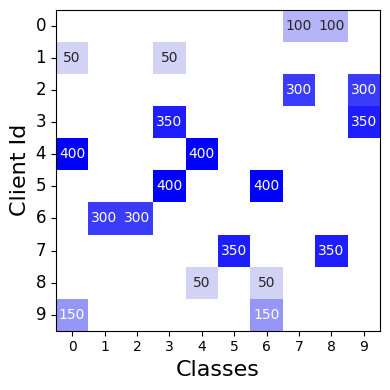

In [33]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(dis_mtx, 
                vmin=0, vmax=np.ceil(np.max(dis_mtx)), 
                fmt=".0f", annot=True, 
                cmap=sns.color_palette("light:b", as_cmap=True), cbar=False,
                mask=(dis_mtx==0))

ax.set_yticklabels(labels=[i for i in range(num_clients)], rotation=0, fontsize=12)
# ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0)
ax.set_xlabel("Classes", fontsize=16)
ax.set_ylabel("Client Id", fontsize=16)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'label-skewed.svg'
plt.tight_layout()
plt.savefig(image_name, format=image_format, dpi=1200)

### Practical heterogeneity

#### Sparse and Scarce - old

In [19]:
import numpy as np
import math
import os

total_labels = np.unique(training_data.targets).tolist()
print(total_labels)

"""
Given the min/max data volume of any client is 20/60, we have:
Table of dirichlet(alpha) w.r.t sparsity and number of classes

        cf10    cf100   TINY    Image
        10	    100	    200	    1000
0.975	X.00	0.41	1.29    X.00
0.950	X.00	1.28	4.20    X.00
0.925	X.00	2.55	9.18    X.00
0.900	X.00	4.24	19.36	X.00
0.875	0.06	6.43 	X.00	X.00
0.850	0.13    9.50 	X.00	X.00

"""

alpha = 0.13
s = 0.850
dataset = "cifar10"

min_sample_per_client = 20
max_sample_per_client = 60

print("min/max : {}/{}".format(min_sample_per_client, max_sample_per_client))

num_clients = 10

total_label = len(total_labels)
label_list = [i for i in total_labels]

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

label_dist = np.random.dirichlet([alpha/total_label for i in range(total_label)], num_clients)
label_nums = np.zeros([num_clients, total_label])

for client_idx in range(num_clients):
    local_label_dist = label_dist[client_idx].tolist()
    sample_this_client = np.random.randint(min_sample_per_client, max_sample_per_client + 1)
    
    for label, proportion in zip(label_list, local_label_dist):
        sample_this_label = round(proportion * sample_this_client)
        if sample_this_label > 0:
            label_nums[client_idx, label] = sample_this_label
            
            idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
            idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
                        
            label_1_idxes = np.random.choice(idxes_1, sample_this_label, replace=False)
            label_2_idxes = np.random.choice(idxes_2, max(5, int(np.ceil(sample_this_label/2))), replace=False)
            
            training_dict_client[client_idx] += label_1_idxes.tolist()
            testing_dict_client[client_idx] += label_2_idxes.tolist()
            
            training_idxs_labels[label_1_idxes] -= 100
            # testing_idxs_labels[label_2_idxes] -= 100


coverred_labels = np.sum(label_nums, axis=0, keepdims=True)
if (coverred_labels == 0).any():
    # print("Not coverring all labels!")
    raise Exception("Not coverring all labels!")

print("Total data used: {}/{} = {}%".format(np.sum(coverred_labels), len(training_data), round(100 * np.sum(coverred_labels)/len(training_data), 2)))
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/{dataset}/dirichlet/sparsity_{s}/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
np.savetxt(f"{savepath}/stats.csv", label_nums, fmt="%d", delimiter=",")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
min/max : 20/60
[[ 0.  0.  0.  0.  0.  0.  0. 42.  0.  0.]
 [ 0.  0.  0.  0. 44.  0.  0.  0.  0.  1.]
 [15. 37.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 35.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  0. 33.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 17.  2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. 23.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0. 24.]
 [ 0. 16.  0.  0.  0.  6.  0.  0.  0.  0.]]
Total data used: 327.0/50000 = 0.65%


#### Sparse and Scarse

[5869 3916 4110 4035 3283 3826 3009 4273 5675 5691] 0.86
490 61 218.435 70.21321652652013
[6679 4954 4713 4359 3513 3338 3349 4111 4634 4035] 0.85
458 73 218.425 63.62722982340187
[5936 4102 6281 4068 3458 3979 3957 4519 4044 3359] 0.85
428 83 218.515 58.317748370457515
[5044 3422 5146 3404 3382 2901 3618 7849 3556 5369] 0.85
486 86 218.455 65.40334834700744
[3814 5746 4992 6270 3709 3174 4529 3422 4196 3840] 0.85
389 66 218.46 62.58321180636226
[4336 4483 5503 3393 5123 5168 4827 3247 3602 4010] 0.85
390 78 218.46 57.59851039740524
[5747 4005 1930 3494 5821 3380 4967 3681 4664 6002] 0.86
453 107 218.455 64.9642053364774
[3883 2701 4147 4813 4852 4792 5344 3733 4679 4755] 0.85
406 80 218.495 62.88648483577374
[5374 5206 3917 2821 5077 4777 5125 3868 3914 3613] 0.86
477 101 218.46 62.98061924116021
[5574 3047 3041 4400 4990 3912 4576 4510 5858 3776] 0.85
475 90 218.42 65.28264394155616
[6246 6496 3768 3360 4351 3579 3056 4120 5244 3477] 0.86
415 72 218.485 63.71027997897985
[5069 4920 3

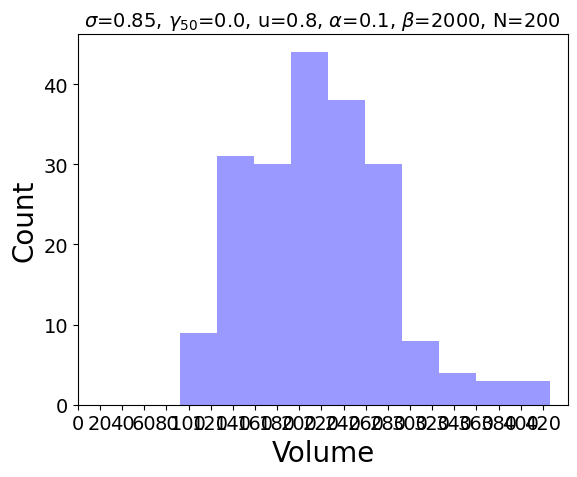

In [3]:
total_datavol = len(training_data)
u = 0.8
alpha = 0.1
num_clients = 200
beta = num_clients * 10

unique_labels = sorted(np.unique(training_data.targets))
num_labels = len(unique_labels)
per_class_max_volume = total_datavol / num_labels
offset = 0.1 * u * total_datavol/num_clients
# Generate data distribution matrix
count = 0
while True:
    count += 1
    volume_dist = np.random.dirichlet([beta/num_clients for i in range(num_clients)])
    # volume_dist = np.random.normal(loc=1, scale=0.1, size=num_clients)/num_clients
    volume_dist = offset + np.int64(volume_dist * total_datavol * u)
    label_dist = np.random.dirichlet([alpha/num_labels for i in range(num_labels)], num_clients)
    distribution = np.int64(label_dist * volume_dist.reshape(num_clients, 1))
    sparsity = round(np.sum(distribution == 0)/(num_clients * num_labels), 2)
    by_class_clientele_volume = np.sum(distribution, axis=0)
    print(by_class_clientele_volume, sparsity)
    by_client_volume = np.sum(distribution, axis=1)
    print(np.max(by_client_volume), np.min(by_client_volume), np.mean(by_client_volume), np.std(by_client_volume))
    
    if not (by_class_clientele_volume > per_class_max_volume).any():
        print(f"Succeed generating data distribution after {count} trails")
        
        # Distribute sample indices
        per_label_indices = {}
        for label in unique_labels:
            # per_label_indices[label] = np.random.choice(np.where(training_data.targets == 0)[0].tolist(), 
            #                                             size=by_class_clientele_volume[label], 
            #                                             replace=False)
            per_label_indices[label] = np.where(training_data.targets == label)[0].tolist()
            
        training_dict_client = {client_id:[] for client_id in range(num_clients)}
        testing_dict_client = {client_id:[] for client_id in range(num_clients)}

        for client_idx in range(num_clients):
            local_per_label_volume = distribution[client_idx].tolist()
            
            for label in unique_labels:
                this_label_vol = local_per_label_volume[label]
                sample_idxs = np.random.choice(per_label_indices[label], this_label_vol, replace=False)
                training_dict_client[client_idx] += sample_idxs.tolist()
                per_label_indices[label] = list(set(per_label_indices[label]) - set(sample_idxs))
            
        savepath = f"./dataset_idx/{dataset}/new/{num_clients}client/u{u}_alpha{alpha}_beta{beta}/"
        if not Path(savepath).exists():
            os.makedirs(savepath)
        
        json.dump({"u": u, "alpha": alpha, "beta": beta, "sparsity": sparsity, "N": num_clients, 
                   "label_stats": by_class_clientele_volume, 
                   "client_stats": {
                       "volume_mean": np.mean(np.sum(distribution, axis=1)),
                       "volume_std": np.std(np.sum(distribution, axis=1))
                       }
                   }, open(f"{savepath}/infor.json", "w"), cls=NumpyEncoder)
        
        json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
        json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
        np.savetxt(f"{savepath}/stats.csv", distribution, fmt="%d", delimiter=",")
        break
    
    elif count >= 10000:
        print(f"Failed after {count} trails")
        break


import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 14})

plt_data = np.sum(distribution, axis=1)
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(plt_data, color='#9999FF')
ax.set_xlabel("Volume", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_xticks([10* i for i in range(0,int(np.max(plt_data)/10)+1, 2)])

T = 50
scarcity = np.sum(plt_data <= T)/num_clients
ax.set_title(rf"$\sigma$={sparsity}, $\gamma_{{{T}}}$={scarcity}, u={u}, $\alpha$={alpha}, $\beta$={beta}, N={num_clients}", fontsize=14)
fig.tight_layout()

image_format = 'svg' # e.g .png, .svg, etc.
image_name = f'{savepath}/volume-stats.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

image_format = 'png' # e.g .png, .svg, etc.
image_name = f'{savepath}/volume-stats.png'
fig.savefig(image_name, format=image_format, dpi=1200)
print("Done plotting")

#### Dirichlet

In [24]:
import numpy as np
import math
import os

total_labels = np.unique(training_data.targets).tolist()
print(total_labels)

alpha = 0.13

min_sample_per_client = 200
max_sample_per_client = 600

num_clients = 10

total_label = len(total_labels)
label_list = [i for i in total_labels]

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

label_dist = np.random.dirichlet([alpha/total_label for i in range(total_label)], num_clients)
label_nums = np.zeros([num_clients, total_label])

for client_idx in range(num_clients):
    local_label_dist = label_dist[client_idx].tolist()
    sample_this_client = np.random.randint(min_sample_per_client, max_sample_per_client + 1)
    
    for label, proportion in zip(label_list, local_label_dist):
        sample_this_label = round(proportion * sample_this_client)
        if sample_this_label > 0:
            label_nums[client_idx, label] = sample_this_label
            
            idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
            idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
            
            label_1_idxes = np.random.choice(idxes_1, sample_this_label, replace=False)
            label_2_idxes = np.random.choice(idxes_2, max(5, int(np.ceil(sample_this_label/2))), replace=False)
            
            training_dict_client[client_idx] += label_1_idxes.tolist()
            testing_dict_client[client_idx] += label_2_idxes.tolist()
            
            training_idxs_labels[label_1_idxes] -= 100
            testing_idxs_labels[label_2_idxes] -= 100

coverred_labels = np.sum(label_nums, axis=0, keepdims=True)
if (coverred_labels == 0).any():
    # print("Not coverring all labels!")
    raise Exception("Not coverring all labels!")

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/cifar10/dirichlet/dir_{alpha}/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
np.savetxt(f"{savepath}/stats.csv", label_nums, fmt="%d", delimiter=",")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'Client 10')

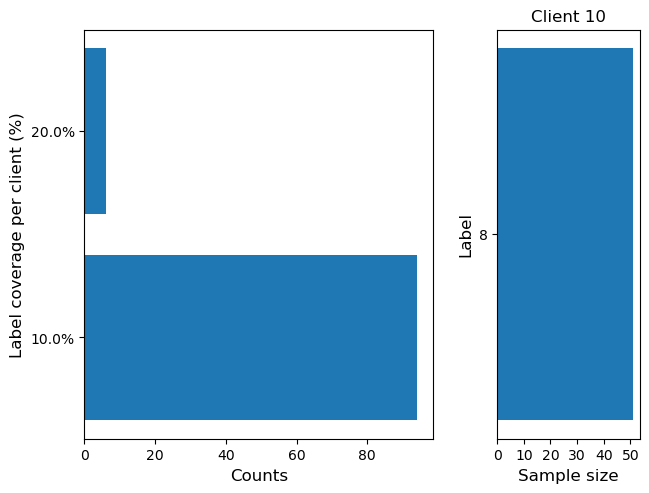

In [8]:
import matplotlib.pyplot as plt
import numpy as np

label_nums = np.loadtxt("./dataset_idx/cifar10/dirichlet/dir_0.01_sparse/100client/stats.csv", delimiter=',')
total_label = label_nums.shape[1]

fig, axes = plt.subplot_mosaic("AAC;AAC")
fig.tight_layout(pad=1.5)

label_stats = np.sum(label_nums > 0, axis=1, keepdims=True)
unique, counts = np.unique(label_stats, return_counts=True)

axes['A'].barh(y=[str(round(i/total_label * 100, 0)) + "%" for i in unique], width=counts)
axes['A'].set_ylabel("Label coverage per client (%)", fontsize=12)
axes['A'].set_xlabel("Counts", fontsize=12)

client_id = 10
bar_data_x = np.where(label_nums[client_id] > 0)[0]
bar_data_h = label_nums[client_id][bar_data_x]
axes['C'].barh(y=[str(i) for i in bar_data_x], width=bar_data_h)
axes['C'].set_ylabel("Label", fontsize=12)
axes['C'].set_xticks(range(0, int(np.max(label_nums[client_id])) + 5, int(np.max(label_nums[client_id])/5)))
axes['C'].set_xlabel("Sample size", fontsize=12)
axes['C'].set_title("Client {}".format(client_id), fontsize=12)

### Knn-per's practical heterogeneity

In [3]:
import random, time
import numpy as np


def iid_divide(l, g):
    """
    https://github.com/TalwalkarLab/leaf/blob/master/data/utils/sample.py
    divide list `l` among `g` groups
    each group has either `int(len(l)/g)` or `int(len(l)/g)+1` elements
    returns a list of groups
    """
    num_elems = len(l)
    group_size = int(len(l) / g)
    num_big_groups = num_elems - g * group_size
    num_small_groups = g - num_big_groups
    glist = []
    for i in range(num_small_groups):
        glist.append(l[group_size * i: group_size * (i + 1)])
    bi = group_size * num_small_groups
    group_size += 1
    for i in range(num_big_groups):
        glist.append(l[bi + group_size * i:bi + group_size * (i + 1)])
    return glist


def split_list_by_indices(l, indices):
    """
    divide list `l` given indices into `len(indices)` sub-lists
    sub-list `i` starts from `indices[i]` and stops at `indices[i+1]`
    returns a list of sub-lists
    """
    res = []
    current_index = 0
    for index in indices:
        res.append(l[current_index: index])
        current_index = index

    return res


def by_labels_non_iid_split(dataset, n_classes, n_clients, n_clusters, alpha, frac, seed=1234):
    """
    split classification dataset among `n_clients`. The dataset is split as follow:
        1) classes are grouped into `n_clusters`
        2) for each cluster `c`, samples are partitioned across clients using dirichlet distribution

    Inspired by the split in "Federated Learning with Matched Averaging"__(https://arxiv.org/abs/2002.06440)

    :param dataset:
    :type dataset: torch.utils.Dataset
    :param n_classes: number of classes present in `dataset`
    :param n_clients: number of clients
    :param n_clusters: number of clusters to consider; if it is `-1`, then `n_clusters = n_classes`
    :param alpha: parameter controlling the diversity among clients
    :param frac: fraction of dataset to use
    :param seed:
    :return: list (size `n_clients`) of subgroups, each subgroup is a list of indices.
    """
    if n_clusters == -1:
        n_clusters = n_classes

    rng_seed = (seed if (seed is not None and seed >= 0) else int(time.time()))
    rng = random.Random(rng_seed)
    np.random.seed(rng_seed)

    all_labels = list(range(n_classes))
    rng.shuffle(all_labels)
    clusters_labels = iid_divide(all_labels, n_clusters)

    label2cluster = dict()  # maps label to its cluster
    for group_idx, labels in enumerate(clusters_labels):
        for label in labels:
            label2cluster[label] = group_idx

    # get subset
    n_samples = int(len(dataset) * frac)
    selected_indices = rng.sample(list(range(len(dataset))), n_samples)

    clusters_sizes = np.zeros(n_clusters, dtype=int)
    clusters = {k: [] for k in range(n_clusters)}
    for idx in selected_indices:
        _, label = dataset[idx]
        group_id = label2cluster[label]
        clusters_sizes[group_id] += 1
        clusters[group_id].append(idx)

    for _, cluster in clusters.items():
        rng.shuffle(cluster)

    clients_counts = np.zeros((n_clusters, n_clients), dtype=np.int64)  # number of samples by client from each cluster

    for cluster_id in range(n_clusters):
        weights = np.random.dirichlet(alpha=alpha * np.ones(n_clients))
        clients_counts[cluster_id] = np.random.multinomial(clusters_sizes[cluster_id], weights)

    clients_counts = np.cumsum(clients_counts, axis=1)

    clients_indices = [[] for _ in range(n_clients)]
    for cluster_id in range(n_clusters):
        cluster_split = split_list_by_indices(clusters[cluster_id], clients_counts[cluster_id])

        for client_id, indices in enumerate(cluster_split):
            clients_indices[client_id] += indices

    return clients_indices

In [6]:
output = by_labels_non_iid_split(training_data, n_classes=10, n_clients=100, n_clusters=-1, alpha=0.1, frac=0.01, seed=1234)

In [7]:
output

[[],
 [29977, 53507],
 [59555, 4521, 44888, 3150, 26218],
 [37104],
 [4805, 55316],
 [4893],
 [25902, 59605, 9422, 56639, 31529, 39417, 50404, 53394, 31323],
 [],
 [],
 [15236],
 [],
 [44664, 44293],
 [7839, 10145],
 [19570],
 [],
 [16693, 43942, 15346, 54862],
 [7088, 28577],
 [],
 [5567],
 [],
 [3128],
 [20014, 47549, 53271, 50092],
 [54936],
 [],
 [50526, 10129],
 [],
 [8118, 49779, 28362],
 [37024, 13369],
 [57503],
 [6756, 11088, 45143, 29762, 27944, 40358, 34825],
 [],
 [1167],
 [50401, 15519, 55547, 50688, 55717, 11999, 2490, 31324, 10951, 49442],
 [],
 [],
 [44245, 2448, 9453, 33769, 58677],
 [9735, 21698, 13504, 30441, 573, 51187, 24729],
 [20513],
 [22394, 58153, 4493],
 [53925],
 [45883, 10651],
 [40847, 24939, 21665, 211],
 [],
 [12988, 15047, 56132, 39586, 9270, 57702, 19493, 1953, 26778],
 [23190, 10818, 52676],
 [],
 [1777, 2679, 36865, 4501, 43793, 24340],
 [27602, 31190, 25886, 31861],
 [],
 [31525, 21118, 4133, 34742, 25653, 59789, 32801, 34744, 5982, 29251, 51693],
 

### By-class Dirichlet Non-iid

In [3]:
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [5]:
import numpy as np
import math
import os


total_labels = np.unique(training_data.targets).tolist()
# print(total_labels)

alpha = 50
u = 0.02
num_clients = 200
num_desire = 150

total_label = len(total_labels)
label_list = [i for i in total_labels]

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

count = 0
while True:
    count += 1

    label_dist = np.random.dirichlet([alpha/num_clients for i in range(num_clients)], total_label).T
    by_class_volume = u * len(training_data) / total_label
    label_dist = np.int64(by_class_volume * label_dist)
    
    client_volume = np.sum(label_dist, axis=1)
    tmp = np.array([i + 1 for i in range(num_clients)]) * (client_volume > 0) - 1
    result = label_dist[tmp[tmp>-1]]
    
    if result.shape[0] >= num_desire:
        print(f"Success after {count} attempt(s). Stop!")
        training_dict_client = {client_id:[] for client_id in range(num_desire)}
        testing_dict_client = {client_id:[] for client_id in range(num_desire)}
        
        result = result[0:num_desire]
        
        for client_idx in range(num_desire):
            local_label_dist = result[client_idx].tolist()
            
            for label, sample_this_label in enumerate(local_label_dist):                
                if sample_this_label > 0:
                    
                    idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
                    idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
                    
                    label_1_idxes = np.random.choice(idxes_1, sample_this_label, replace=False)
                    label_2_idxes = np.random.choice(idxes_2, int(np.ceil(sample_this_label/2)), replace=False)
                    
                    training_dict_client[client_idx] += label_1_idxes.tolist()
                    testing_dict_client[client_idx] += label_2_idxes.tolist()
                    
                    training_idxs_labels[label_1_idxes] -= 100
                    testing_idxs_labels[label_2_idxes] -= 100
        
        sparsity = round(np.sum(result == 0)/(result.shape[0] * total_label), 2)
        savepath = f"./dataset_idx/cifar10/dirichlet/sparsity_{sparsity}/{num_desire}client"
        if not Path(savepath).exists():
            os.makedirs(savepath)
        
        json.dump({"u": u, "alpha": alpha, "sparsity": sparsity, "n_input": num_clients, "n_desire": num_desire}, open(f"{savepath}/infor.json", "w"))
        json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
        json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
        np.savetxt(f"{savepath}/stats.csv", result, fmt="%d", delimiter=",")
        break
        
    elif count >= 10000:
        print(f"{count} attempts failed. Stop!")
        break

Success after 1 attempt(s). Stop!


### Gen I.i.d data

In [ ]:
num_clients = 30
sample_per_client = 200

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T


for client_id in range(num_clients):    
    idxes_1 = training_idxs_labels[:,0]
    idxes_2 = testing_idxs_labels[:,0]
    
    label_1_idxes = np.random.choice(idxes_1, sample_per_client, replace=False)
    label_2_idxes = np.random.choice(idxes_2, int(sample_per_client/4), replace=False)
    
    training_dict_client[client_id] += label_1_idxes.tolist()
    testing_dict_client[client_id] += label_2_idxes.tolist()
    
    training_idxs_labels[label_1_idxes] -= 100
    testing_idxs_labels[label_2_idxes] -= 100

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/mnist/iid/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/mnist_iid.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/mnist_iid_test.json", "w"), cls=NumpyEncoder)

### Practical for tiny imagenet / medical

In [4]:
import numpy as np
import math
import os

total_labels = np.unique(training_data.dataset.targets).tolist()
print(total_labels)

alpha = 5

min_sample_per_client = 20
max_sample_per_client = 60

num_clients = 500

total_label = len(total_labels)
label_list = [i for i in total_labels]

labels = np.array(training_data.dataset.targets)[training_data.indices].tolist()
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = np.array(testing_data.dataset.targets)[testing_data.indices].tolist()
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

label_dist = np.random.dirichlet([alpha/total_label for i in range(total_label)], num_clients)
label_nums = np.zeros([num_clients, total_label])

for client_idx in range(num_clients):
    local_label_dist = label_dist[client_idx].tolist()
    sample_this_client = np.random.randint(min_sample_per_client, max_sample_per_client + 1)
    
    for label, proportion in zip(label_list, local_label_dist):
        sample_this_label = round(proportion * sample_this_client)
        if sample_this_label > 0:
            label_nums[client_idx, label] = sample_this_label
            
            idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
            idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
                        
            label_1_idxes = np.random.choice(idxes_1, sample_this_label, replace=False)
            label_2_idxes = np.random.choice(idxes_2, max(5, int(np.ceil(sample_this_label/2))), replace=False)
            
            training_dict_client[client_idx] += label_1_idxes.tolist()
            testing_dict_client[client_idx] += label_2_idxes.tolist()
            
            training_idxs_labels[label_1_idxes] -= 100
            # testing_idxs_labels[label_2_idxes] -= 100

coverred_labels = np.sum(label_nums, axis=0, keepdims=True)
if (coverred_labels == 0).any():
    raise Exception("Not coverring all labels! {}".format(coverred_labels))

print("Total data used: {}/{}".format(np.sum(coverred_labels), len(training_data)))
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/tinyimagenet/dirichlet/dir_{alpha}_sparse/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
np.savetxt(f"{savepath}/stats.csv", label_nums, fmt="%d", delimiter=",")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Total data used: 19080.0/80000


In [1]:
import numpy as np
import torch

In [2]:
a = torch.randn([10])
a

tensor([ 0.3481,  0.8665, -0.7567, -0.3599,  1.7869, -0.7438,  0.6082,  0.5114,
        -0.4556,  0.5690])

In [6]:
a[1:-1]

tensor([ 0.8665, -0.7567, -0.3599,  1.7869, -0.7438,  0.6082,  0.5114, -0.4556])

In [7]:
a_np = a[1:-1].numpy()
a_np

array([ 0.8664599 , -0.7566685 , -0.3598654 ,  1.7868515 , -0.74376106,
        0.60816854,  0.51137835, -0.4555607 ], dtype=float32)

In [10]:
a_np[[1,2,3]] = 0

In [11]:
a_np

array([ 0.8664599 ,  0.        ,  0.        ,  0.        , -0.74376106,
        0.60816854,  0.51137835, -0.4555607 ], dtype=float32)

In [14]:
np.where(a_np != 0)[0]

array([0, 4, 5, 6, 7])

In [19]:
b = np.random.rand(8)
b

array([0.71349951, 0.47656529, 0.30668635, 0.61404144, 0.06606552,
       0.17665606, 0.9452477 , 0.48429536])

In [20]:
b[np.where(a_np != 0)[0]]

array([0.71349951, 0.06606552, 0.17665606, 0.9452477 , 0.48429536])

In [23]:
np.cumsum(b).argmax()

7